In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
!pip install -q pretty_midi

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
import pretty_midi

In [ ]:
conn = sqlite3.connect('/gdrive/My Drive/wjazzd.db')
conn.row_factory = sqlite3.Row


# Visualize Note Data

In [ ]:
def visualize_tune(results):
  # Create a Gantt chart of the solo's melody
  # Additionally, create a section Gantt chart, aligning the melody with the
  # chord, form, chorsu, idea, phrase, and bar annotations

# Declaring a figure "gnt"
    fig, (gnt, sgnt) = plt.subplots(2)

# Setting Y-axis limits
    gnt.set_ylim(min(results.pitch)-1.0, max(results.pitch)+1.0)
    print("Min pitch: ", min(results['pitch']))
    print("Max pitch: ", max(results['pitch']))

    max_time = (results.onset.iloc[-1]+results.duration.iloc[-1])

# Setting X-axis limits
    gnt.set_xlim(0, max_time)

# Setting labels for x-axis and y-axis
    gnt.set_xlabel('Solo time')
    sgnt.set_xlabel('Solo time')
    gnt.set_ylabel('Pitch')

# Setting ticks on y-axis
    gnt.set_yticks(np.linspace(min(results.pitch), max(results.pitch), int(max(results.pitch)-min(results.pitch)+1)))
# Labelling tickes of y-axis

# Setting graph attribute
    gnt.grid(True)
    sgnt.grid(True)

    for idx, note in results.iterrows():
        gnt.broken_barh([(note.onset,note.duration)], (note.pitch-0.2,0.4), facecolors=('tab:red'))

#Process for form, chorus, and chord boundaries
#We create the boundaries so that we can associate specific melody notes with them
#This is because the sections are denoted by id of the melody event, not the eventid in the melody table
# See: https://jazzomat.hfm-weimar.de/dbformat/dbformat.html

    section_categories = ['CHORD', 'FORM', 'CHORUS', 'IDEA', 'PHRASE', 'bar']

    boundaries = {}
    # Create the boundaries for each type of section
    for type in section_categories:
        boundaries[type] = []
        boundaries[type].append({"start": 0, "val": results.iloc[0][type]})
        val = ''
        last_val = ''
        for note_val in results.to_dict(orient="records"):
            if val is not note_val[type]:
                val = note_val[type]
                boundaries[type].append({"start": note_val['onset'], "val": note_val[type]})
            last_val = note_val
        boundaries[type].append({"start": last_val['onset']+last_val['duration'], "val": last_val[type]})

    print("boundaries:")
    print(boundaries)

    gnt.set_xticks([boundaries['bar'][x]['start'] for x in range(len(boundaries['bar']))])

    sgnt.set_ylim(-0.5, len(boundaries.keys()))
    sgnt.set_xlim(0, max_time)

    #Print the gantt chart for each type of section breakdown
    key_enum = 0
    for key in section_categories:
        sec_enum = 0
        for i in range(len(boundaries[key])):
            if(i+1 >= len(boundaries[key])):
                break
            time_diff = boundaries[key][i+1]["start"] - boundaries[key][i]["start"]
            sgnt.broken_barh([(boundaries[key][i]["start"],time_diff)], 
                  (key_enum-0.3, 0.6), 
                  facecolors='C{:d}'.format(sec_enum))

            sgnt.annotate(boundaries[key][i]["val"], # this is the text
                  (boundaries[key][i]["start"],key_enum), # these are the coordinates to position the label
                  textcoords="offset points", # how to position the text
                  xytext=(10,0), # distance from text to points (x,y)
                  ha='center') # horizontal alignment can be left, right or center
            sec_enum += 1
        key_enum += 1

    sgnt.set_yticks(range(len(section_categories)))
    sgnt.set_yticklabels(section_categories)

    fig.set_size_inches(23, 20)

    fig2, (ax3, ax4) = plt.subplots(nrows=2, ncols=1) # two axes on figure

    fig2.suptitle("Statistical Distributions (Training Data)")
    fig2.set_size_inches(18.5, 10.5)

    ax3.hist(results.pitch, bins=int(max(results.pitch)-min(results.pitch)+1))
    ax3.set_xlim(25, 110)
    
    ax3.set_xlabel('MIDI Pitch Value')

    ax4.hist(results.duration, bins=6)
    ax4.set_xlabel('Note Duration')

    plt.show()

In [ ]:
def visualize_notes(results):
# Visualize notes independent of the section data
# Creates a melody Gantt Chart
# Creates a pitch and duration distribution histogram

# Declaring a figure "gnt"
    fig, gnt = plt.subplots(1)

# Setting Y-axis limits
    gnt.set_ylim(min(results.pitch)-1.0, max(results.pitch)+1.0)
    print("Min pitch: ", min(results['pitch']))
    print("Max pitch: ", max(results['pitch']))

    max_time = sum(results.step)

# Setting X-axis limits
    gnt.set_xlim(0, max_time)

# Setting labels for x-axis and y-axis
    gnt.set_xlabel('Solo time')
    gnt.set_ylabel('Pitch')

# Setting ticks on y-axis
    gnt.set_yticks(np.linspace(min(results.pitch), max(results.pitch), int(max(results.pitch)-min(results.pitch)+1)))
# Labelling tickes of y-axis

# Setting graph attribute
    gnt.grid(True)

    start = 0
    for idx, note in results.iterrows():
        gnt.broken_barh([(start,note.duration)], (note.pitch-0.2,0.4), facecolors=('tab:red'))
        start += note.step

    fig.set_size_inches(23, 20)

    fig2, (ax2, ax3) = plt.subplots(nrows=2, ncols=1) # two axes on figure
    fig2.suptitle("Statistical Distributions (Generated Solo)")
    fig2.set_size_inches(18.5, 10.5)

    ax2.hist(results.pitch, bins=int(max(results.pitch)-min(results.pitch)+1))
    ax2.set_xlim(25, 110)
    ax2.set_xlabel("MIDI Pitch Value")

    ax3.hist(results.duration, bins=20)
    ax3.set_xlabel("Note Duration")

    plt.show()

In [ ]:
def print_distributions(note_collection, temps):
  #Display the pitch distributions for an arbitrary set of MIDI notes

    fig, axes = plt.subplots(nrows=2, ncols=2)
    print(type(axes))
    fig.suptitle("Pitch Distributions of Generated Solos")
    fig.set_size_inches(18.5, 10.5)

    print(len(note_collection))
    for idx, ax in enumerate(axes.reshape(4)):
      print(idx)
      ax.hist(note_collection[idx].pitch, bins=int(max(note_collection[idx].pitch)-min(note_collection[idx].pitch)+1))
      ax.set_xlim(0, 100)
      ax.title.set_text('Temperature: {:02f}'.format(temps[idx]))
      ax.set_xlabel("MIDI Pitch Value")

    plt.show()
    

# Get Solo Information 

10
melid 10
trackid 8
compid 8
recordid 4
performer Benny Carter
title Just Friends
titleaddon 
solopart 1
instrument as
style SWING
avgtempo 204.9
tempoclass UP
rhythmfeel SWING
key Bb-maj
signature 4/4
chord_changes A1: ||Bbj7   |Bbj7   |Bb-7   |Eb7   |Fj7   |Fj7   |Ab-7   |Db7   |G-7   |C7   |A-7   |D-7   |G7   |G7   |G-7   |C7 B7 ||
B1: ||Bbj7   |Bbj7   |Bb-7   |Eb7   |Fj7   |Fj7   |Ab-7   |Db7   |G-7   |C7   |Em7b5 A7 |D-7   |G7   |G-7 C7 |F6   |C-7 F7 ||
chorus_count 3
Min pitch:  50.0
Max pitch:  82.0
boundaries:
{'CHORD': [{'start': 0, 'val': 'NC'}, {'start': 6.189795918367347, 'val': 'NC'}, {'start': 6.375510204081633, 'val': 'Bbj7'}, {'start': 8.629115646258503, 'val': 'Bb-7'}, {'start': 9.890249433106575, 'val': 'Eb7'}, {'start': 11.07156462585034, 'val': 'Fj7'}, {'start': 13.712834467120182, 'val': 'Ab-7'}, {'start': 14.759183673469387, 'val': 'Db7'}, {'start': 15.777551020408163, 'val': 'G-7'}, {'start': 16.970884353741496, 'val': 'C7'}, {'start': 18.11156462585034, 'val':

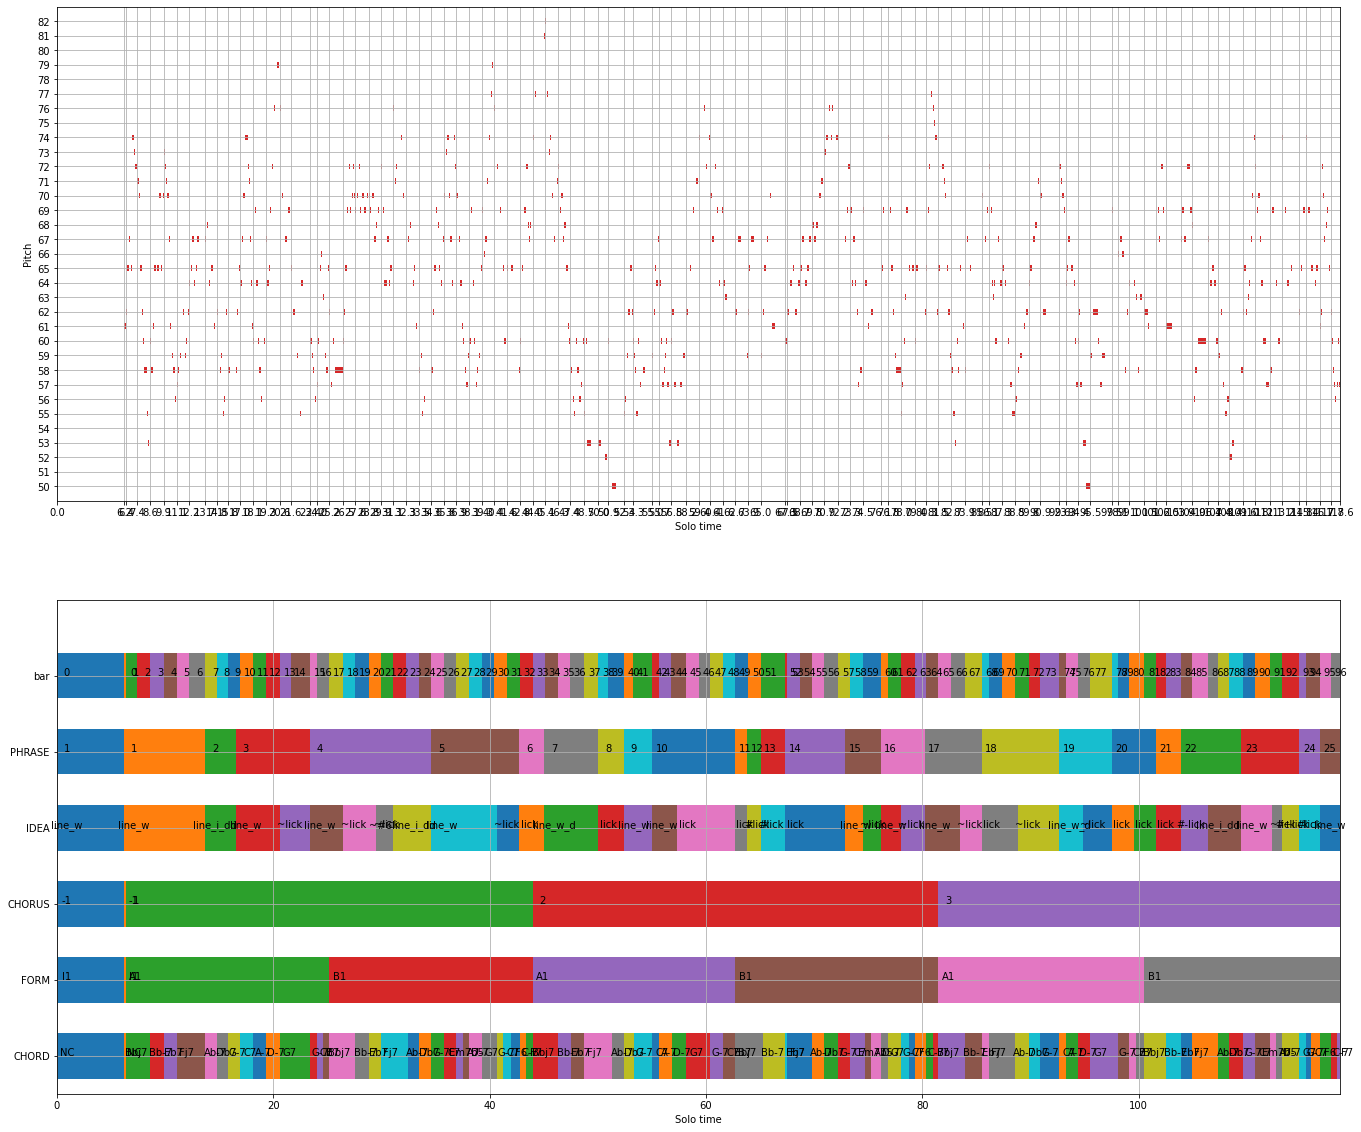

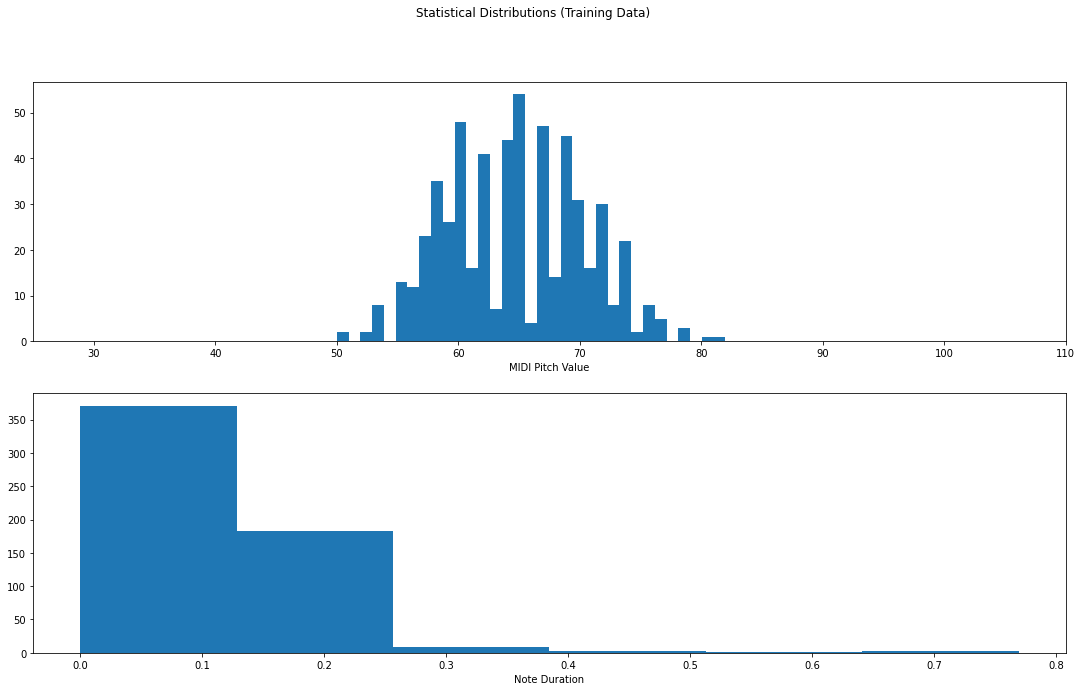

,pitch,step,duration
0,60.0,0.046939,0.036735
1,61.0,0.138776,0.122449
2,62.0,0.134785,0.118367
3,65.0,0.143673,0.117551
4,67.0,0.163991,0.150930
...,...,...,...
563,57.0,0.087755,0.067347
564,56.0,0.157143,0.065306
565,57.0,0.114286,0.085714
566,60.0,0.108163,0.081633


In [ ]:
num_songs = 1 # Number of songs used for training
mid_start = 10 # Starting tune used for training
  
for mid in range(mid_start, mid_start+num_songs):
    print(mid)
    cur = conn.execute("select * FROM solo_info where melid=%s" % mid)
    for tune in cur: #For each tune
        
        for key in tune.keys():
            print(key, tune[key])
            pass 
        
        #create arrays that will be later used for the dataframe 
        pitches = []
        onset = [] 
        duration = []
        chords = []
        steps = []

      # Get the melody of the tune as a database cursor
        melody_cur = conn.execute("select pitch,duration,onset,division,bar,beat,tatum,num,denom,beatprops from melody where melid=%s" % tune['melid'])
        section_cur = conn.execute("select * from sections where melid=%s" % tune['melid'])

      # Extract the melody info from this tune's melody entry
        results = pd.DataFrame.from_records(data = melody_cur.fetchall(), columns = [col[0] for col in melody_cur.description])
        #print(results)
        sections = pd.DataFrame.from_records(data = section_cur.fetchall(), columns = [col[0] for col in section_cur.description])

        annotations = {}
        
        for sec_type in sections.type.unique():
            annotations[sec_type] = []
            for bars in sections.loc[sections.type == sec_type].itertuples():
                for i in range(bars.start, bars.end+1):
                    annotations[sec_type].append(bars.value)

            results[sec_type] = annotations[sec_type]
        visualize_tune(results)

        #create different arrays for the pitch, onsest, duration, and chords(letters)
        pitches.append(results['pitch'])
        onset.append(results['onset'])
        duration.append(results['duration'])
        chords.append(results['CHORD'])

        #new_arr contains step values; step = difference between each onset value 
        step = []
        step = np.diff(onset)
        steps.append(step)
        steps = steps[0][0]
        
        new_arr = np.append(steps, 0)

        #create dataframes for pitch, duration and step. We will use these values for our model   
        pitches = pd.DataFrame(pitches)
        pitches = pitches.transpose()
        
        duration = pd.DataFrame(duration)
        duration = duration.transpose()
        
        stepped = pd.DataFrame(new_arr)
            
        stepped.columns = stepped.columns.astype("str")
        stepped.rename(columns = {'0':'step'},inplace=True)
    
        #horiz contains the dataframe of these three values (for one song, i have to test how this works for multiple songs)
        horiz = pd.concat([pitches, stepped,duration], axis=1)
    
        display(horiz)
    



# Add Stop and Start Columns to DataFrame

In [ ]:
start = []
for i in range(len(horiz)):
    horiz['start'] = horiz.step + horiz.duration
for j in range(len(horiz)):
    horiz['end'] = horiz.duration + horiz.start

# Create Training Dataset

In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([horiz[key] for key in key_order],axis = 1)

#notes_ds contains a dataset of train_notes (points that we will use for training)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

# Get Sequences 
## created a new get sequences 
### (code from TensorFlow.org) They have an RNN project similar to ours, we can use the orginial get sequences if you want, i just didnt want to mess with that block of code atm 


In [ ]:
def create_sequences(dataset: tf.data.Dataset, seq_length: int,norm_val = 128,) -> tf.data.Dataset:
  # Create note sequences and an associated label for training (the immediate next note) 

    seq_length = seq_length+1

    #take 1 extra for the labels (the next note)
    windows = dataset.window(seq_length, shift=1, stride=1,drop_remainder=True)

    #flat_map flattens the "dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    #normalize note pitch
    def pitch_norm(x):
        x = x/[norm_val,1.0,1.0]
        return x

    #split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

        return pitch_norm(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)    

In [ ]:
#sequence length can be changed, might lead to better results if larger 
seq_length = 25

#represents unique values (unique pitches that belong to pretty_midi)
norm_val = 128

#generate the sequences that will be input to the RNN 
seq_ds = create_sequences(notes_ds, seq_length, norm_val)

seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
for seq, target in seq_ds.take(1):
    print(seq.shape)
    print('sequence elements (first 10):', seq[0: 10])
    print()
    print('target:', target)

(25, 3)
sequence elements (first 10): tf.Tensor(
[[0.46875    0.04693878 0.03673469]
 [0.4765625  0.13877551 0.12244898]
 [0.484375   0.13478458 0.11836735]
 [0.5078125  0.14367347 0.11755102]
 [0.5234375  0.16399093 0.15092971]
 [0.5078125  0.15818594 0.12045351]
 [0.578125   0.14426304 0.13206349]
 [0.5703125  0.12421769 0.11632653]
 [0.5625     0.19301587 0.18575964]
 [0.5546875  0.13206349 0.11755102]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=73.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.14947845804988802>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.1349659863945578>}


In [ ]:
# Length of our training dataset 
n_notes = len(horiz)
batch_size = 64 
buffer_size = n_notes - seq_length

train_ds = (seq_ds
           .shuffle(buffer_size)
           .batch(batch_size,drop_remainder = True)
           .cache()
           .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

# Define the MSE loss Function 

In [ ]:
def mse(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

# The model
# The final model consists of a:
#   Input
#   LSTM 1
#   Dropout
#   LSTM 2
#   Flatten
#   Activation
#   Dense (Output)

inputs = tf.keras.Input(shape=input_shape)
lstm1, s1, s2 = tf.keras.layers.LSTM(128, return_sequences=True, return_state=True)(inputs)
do1 = tf.keras.layers.Dropout(0.3)(lstm1)
lstm2, s3, s4 = tf.keras.layers.LSTM(128, return_sequences=True, return_state=True)(do1)
flat = tf.keras.layers.Flatten()(lstm2)
x = tf.keras.layers.Activation('softmax')(flat)

#For a simpler model, uncomment the following line
#x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse,
      'duration': mse,
}

#Use the adam Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

#summary of model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 25, 128),    67584       ['input_1[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 dropout (Dropout)              (None, 25, 128)      0           ['lstm[0][0]']                   
                                                                                              

# Calculate the Loss

In [ ]:
# Evaluate model losses
losses = model.evaluate(train_ds,return_dict = True)
losses

8/8 [==============================] - 6s 182ms/step - loss: 4.9427 - duration_loss: 0.0192 - pitch_loss: 4.8522 - step_loss: 0.0713


{'duration_loss': 0.019207943230867386,
 'loss': 4.942693710327148,
 'pitch_loss': 4.8521904945373535,
 'step_loss': 0.07129538804292679}

In [ ]:
# Compile the model with prescribed attribute weights
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 1.0, #0.05
        'step': 0.01, #1.0
        'duration': 0.01, #1.0
    },
    optimizer=optimizer,
)

In [ ]:
model.evaluate(train_ds, return_dict=True)

8/8 [==============================] - 6s 94ms/step - loss: 4.8531 - duration_loss: 0.0192 - pitch_loss: 4.8522 - step_loss: 0.0713


{'duration_loss': 0.019207943230867386,
 'loss': 4.853095531463623,
 'pitch_loss': 4.8521904945373535,
 'step_loss': 0.07129538804292679}

In [ ]:
# Checkpoint the progress of model training
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/gdrive/My Drive/training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
#Train the model to the data set sequences
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
8/8 [==============================] - 11s 225ms/step - loss: 4.8091 - duration_loss: 0.0147 - pitch_loss: 4.8083 - step_loss: 0.0625
Epoch 2/50
8/8 [==============================] - 2s 201ms/step - loss: 4.7034 - duration_loss: 0.0073 - pitch_loss: 4.7029 - step_loss: 0.0456
Epoch 3/50
8/8 [==============================] - 2s 237ms/step - loss: 4.5965 - duration_loss: 0.0050 - pitch_loss: 4.5961 - step_loss: 0.0356
Epoch 4/50
8/8 [==============================] - 1s 124ms/step - loss: 4.4910 - duration_loss: 0.0052 - pitch_loss: 4.4906 - step_loss: 0.0319
Epoch 5/50
8/8 [==============================] - 1s 131ms/step - loss: 4.3893 - duration_loss: 0.0052 - pitch_loss: 4.3889 - step_loss: 0.0316
Epoch 6/50
8/8 [==============================] - 1s 127ms/step - loss: 4.2924 - duration_loss: 0.0049 - pitch_loss: 4.2921 - step_loss: 0.0318
Epoch 7/50
8/8 [==============================] - 1s 126ms/step - loss: 4.2009 - duration_loss: 0.0049 - pitch_loss: 4.2005 - step_loss

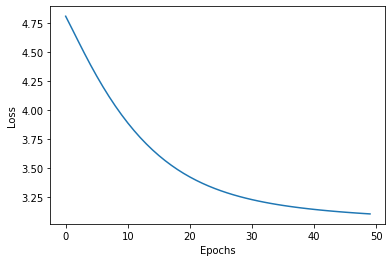

In [ ]:
# Plot the loss over time
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Generate Next Sequence of Notes

In [ ]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
    
    assert temperature > 0
    
    
    #Add batch dimension
    #tf.expand_dims returns a tensor with a length 1 axis inserted at index axis.
    inputs = tf.expand_dims(notes, 0)

    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature

    #draws samples from a categorical distribution.
    pitch = tf.random.categorical(pitch_logits, num_samples=1)

    #tf.squeeze removes dimensions of size 1 from the shape of a tensor
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    #step and duration values should be non-negative
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)


Temperature is a hyperparameter of LSTMs used to control the randomness of predictions by scaling the logits before applying softmax.

Higher temperature creates more confident model, but conservative in results 
Lower temperature leads to more diversity, but also more mistakes 

In [ ]:
def generate_notes(num_predictions, temperature):
  print("Generating {:d} notes with temperature {:f}...".format(num_predictions, temperature))
  #sample_notes gets our dataframe of original pitches, durations, and steps 
  sample_notes = np.stack([horiz[key] for key in key_order], axis=1)
  
  #input_notes takes a subset of sample_notes that is of length seq_length 
  #divide the pitches by the norm_val to represent ranges for pretty_midi library 
  input_notes = (sample_notes[:seq_length] / np.array([norm_val, 1, 1]))
  
  generated_notes = []
  prev_start = 0
  
  for _ in range(num_predictions):
      #predict next note
      pitch,step,duration = predict_next_note(input_notes,model,temperature)
      #calculate start of note
      start = prev_start + step 
      #calculate end of note 
      end = start + duration 
      #format the input notes 
      input_note = (pitch,step,duration)
      #append to generated_notes / call *input_note because we have variable lengths for input_note
      generated_notes.append((*input_note,start,end))
      input_notes = np.delete(input_notes, 0,axis = 0)
      #keep getting next group of notes 
      input_notes = np.append(input_notes,np.expand_dims(input_note,0),axis=0)
      prev_start = start
      
  generated_notes = pd.DataFrame(generated_notes,columns=(*key_order,'start','end'))
  return generated_notes

In [ ]:
# temperature is the "variability" of the resulting solo
temperature = 0.2

#predict the next ___ amount of notes 
num_predictions = 120

generated_notes = generate_notes(num_predictions, temperature)

Generating 120 notes with temperature 0.200000...


# Create a MIDI File

In [ ]:
def notes_to_midi(
    notes: pd.DataFrame,
    out_file: str, 
    instrument_name: str,
    velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:
    #Generate a midi file based on the incoming collection of pitch, duration, and step values

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program(instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(velocity=velocity,pitch=int(note['pitch']),start=start,end=end)

        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

Min pitch:  57
Max pitch:  74


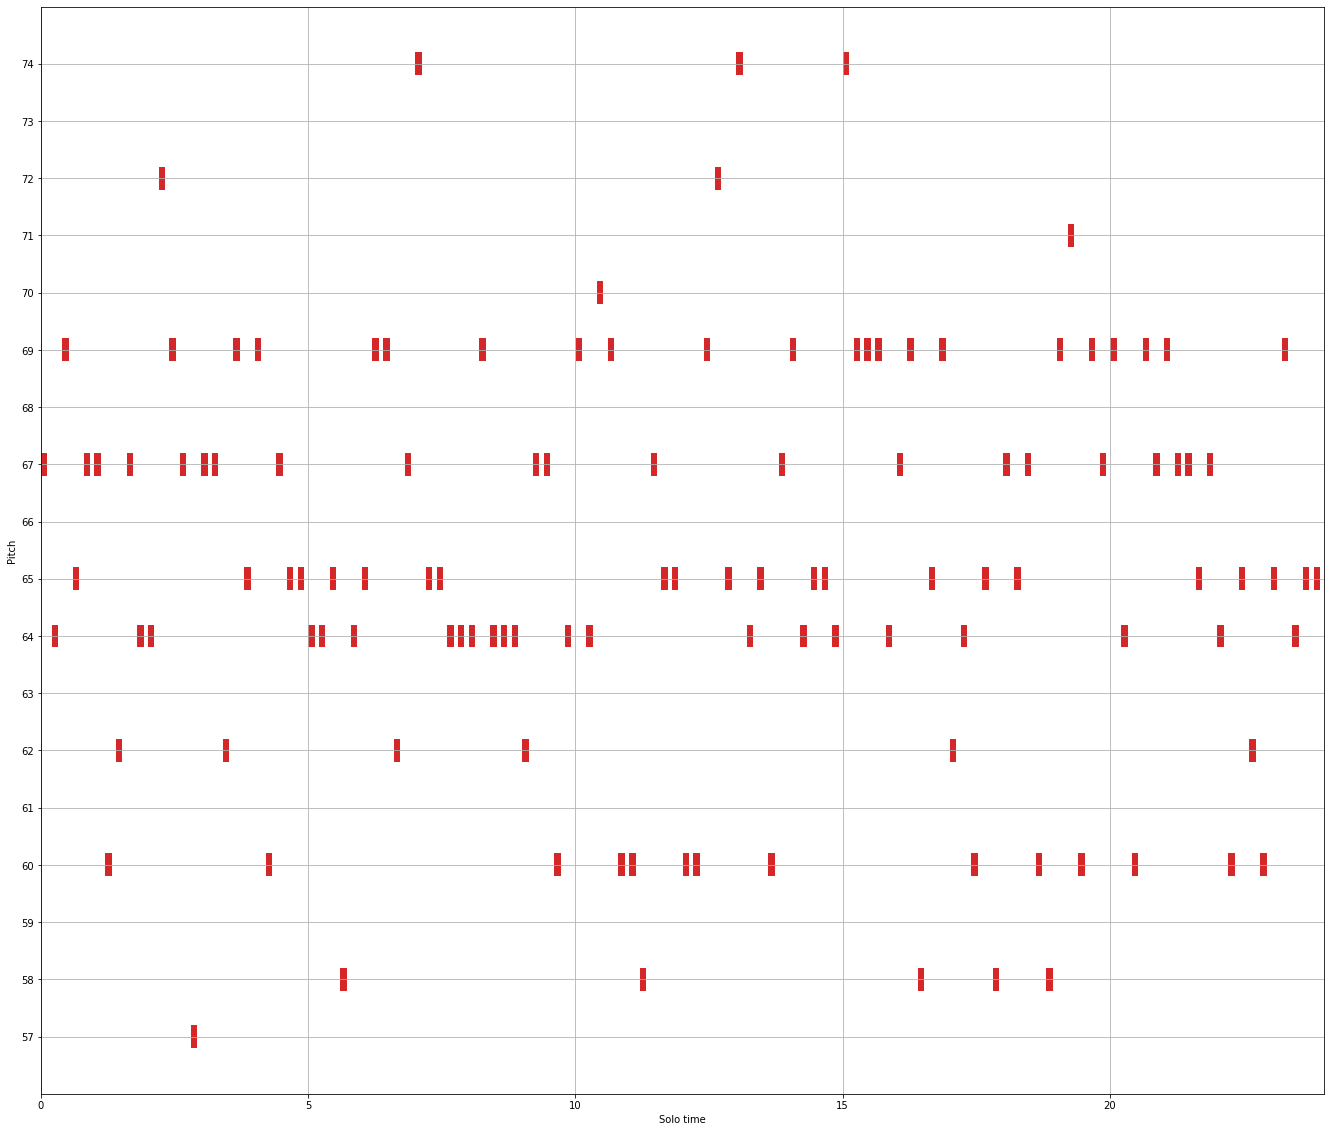

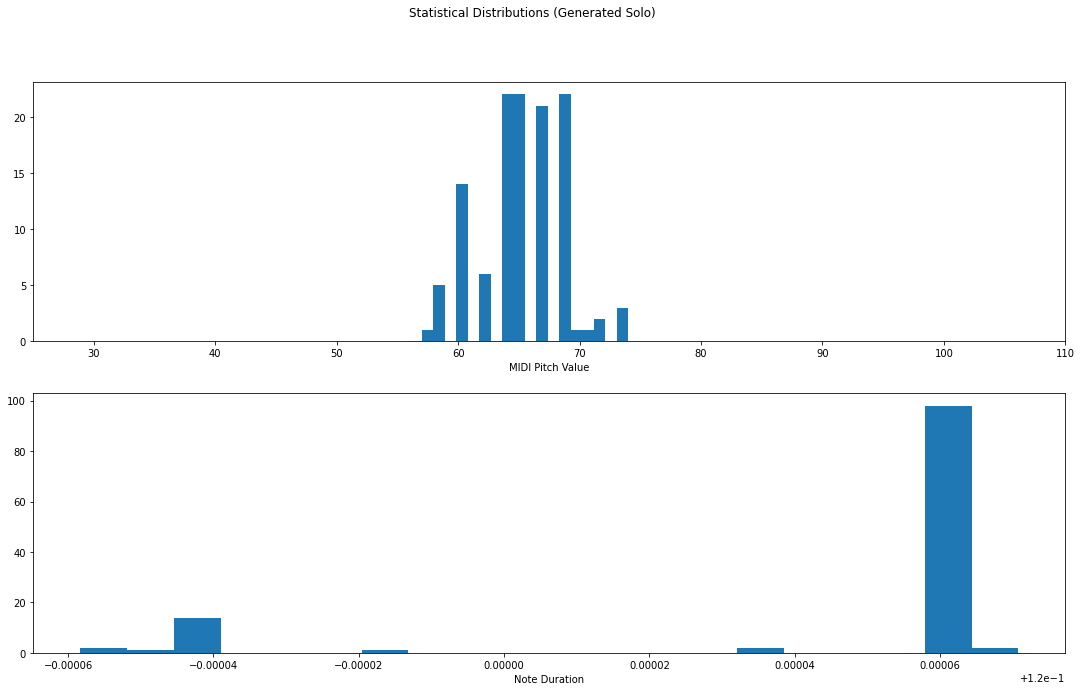

In [ ]:
#once you get the file, you can use an online midi to MP3 converter here: https://www.bearaudiotool.com/
#Or use MIDITrail or equivalent to visualize and listen to the resulting solo
out_file = '/content/OUTPUT.mid'

#Play the solo on the trumpet
instrument_name = 'trumpet'

out_pm = notes_to_midi(generated_notes,out_file = out_file,instrument_name=instrument_name)

visualize_notes(generated_notes)

Generating 120 notes with temperature 0.100000...
Min pitch:  58
Max pitch:  69


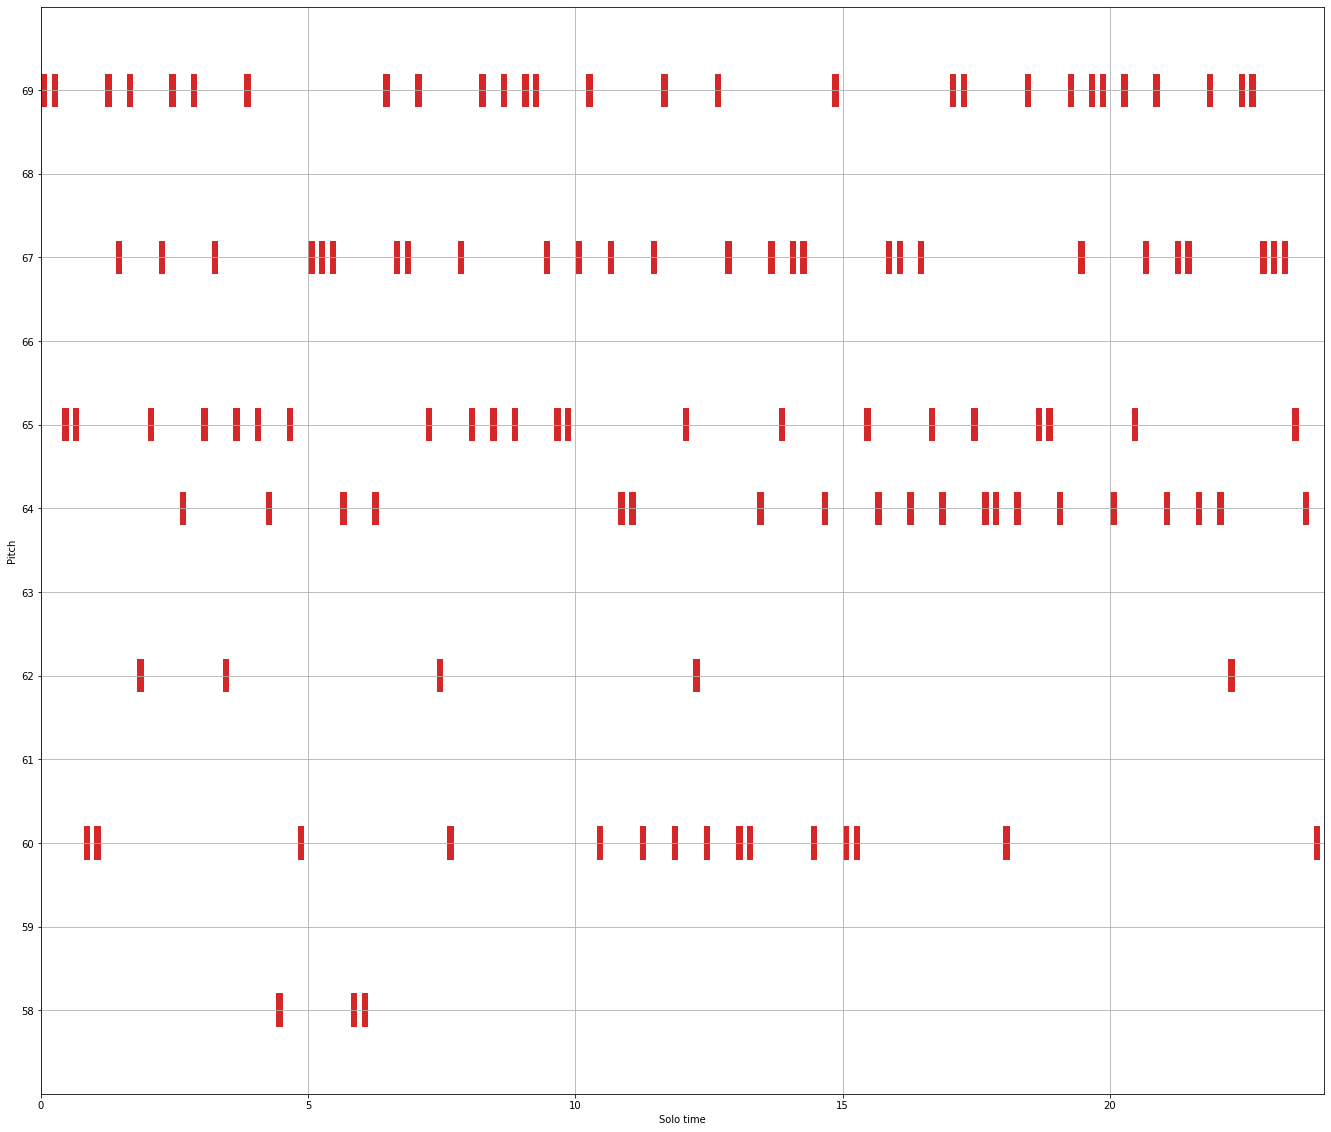

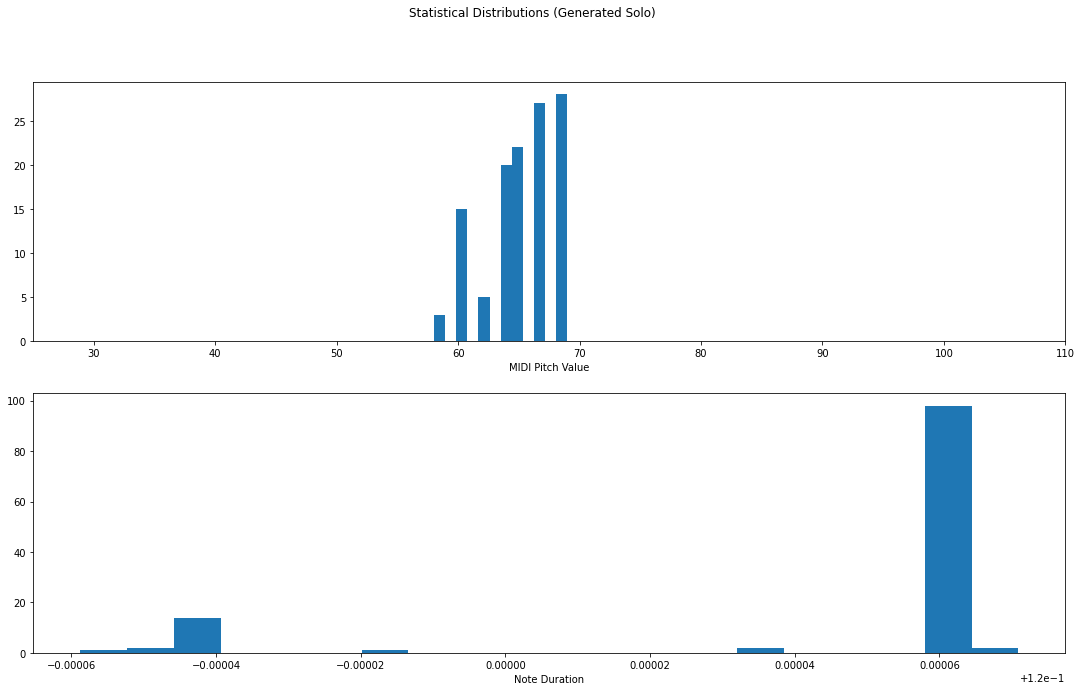

Generating 120 notes with temperature 0.500000...
Min pitch:  56
Max pitch:  72


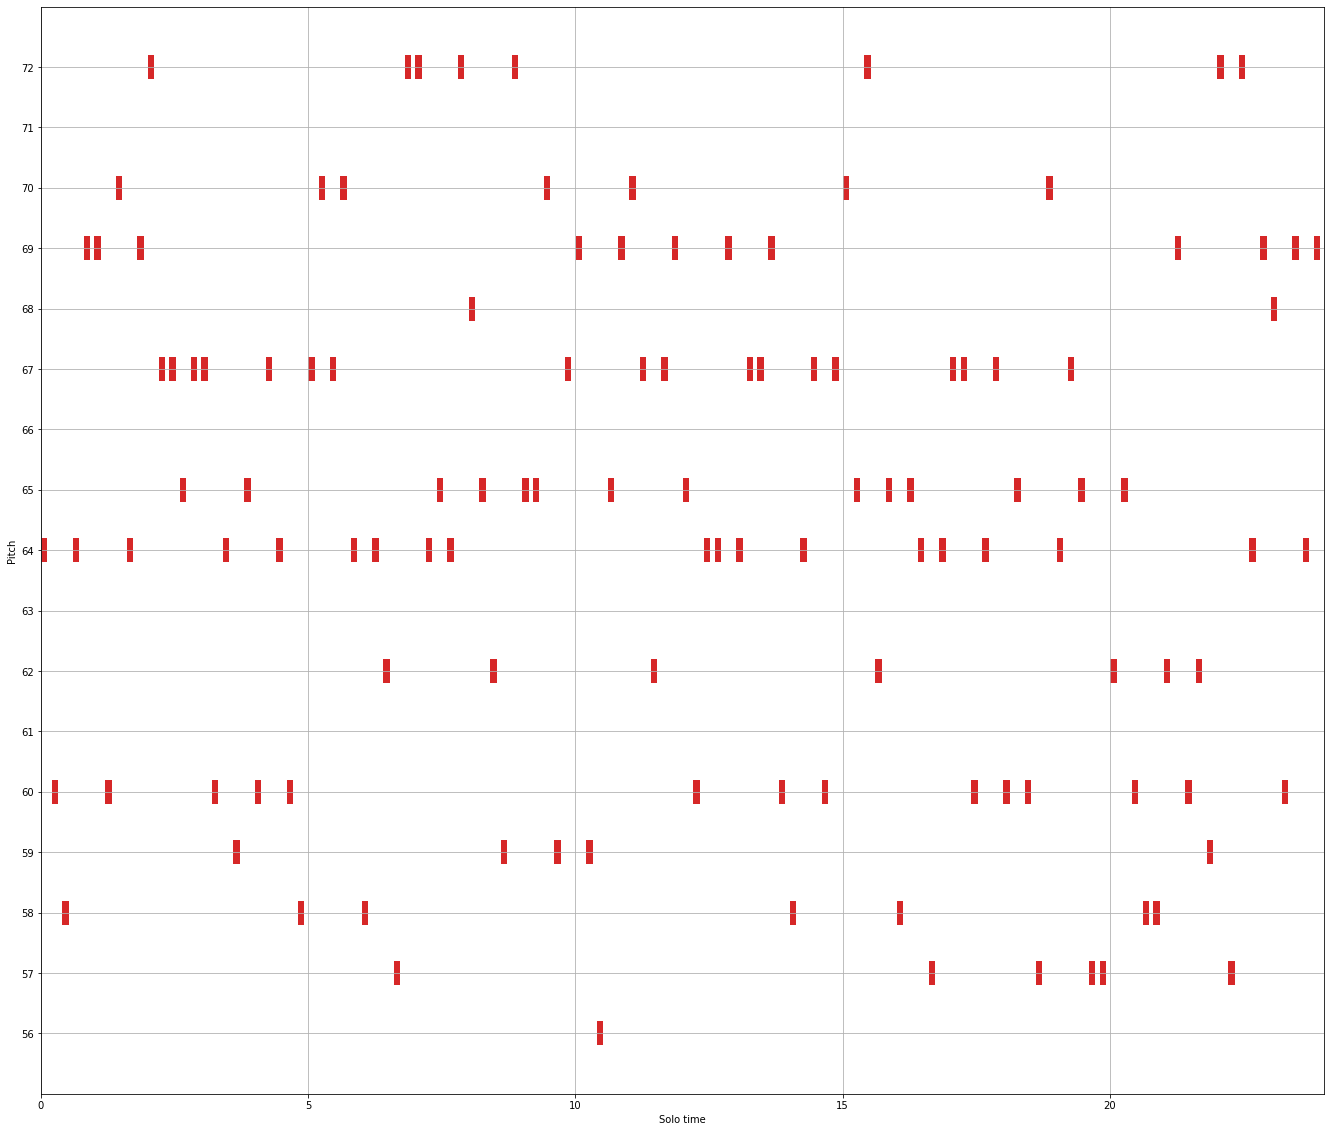

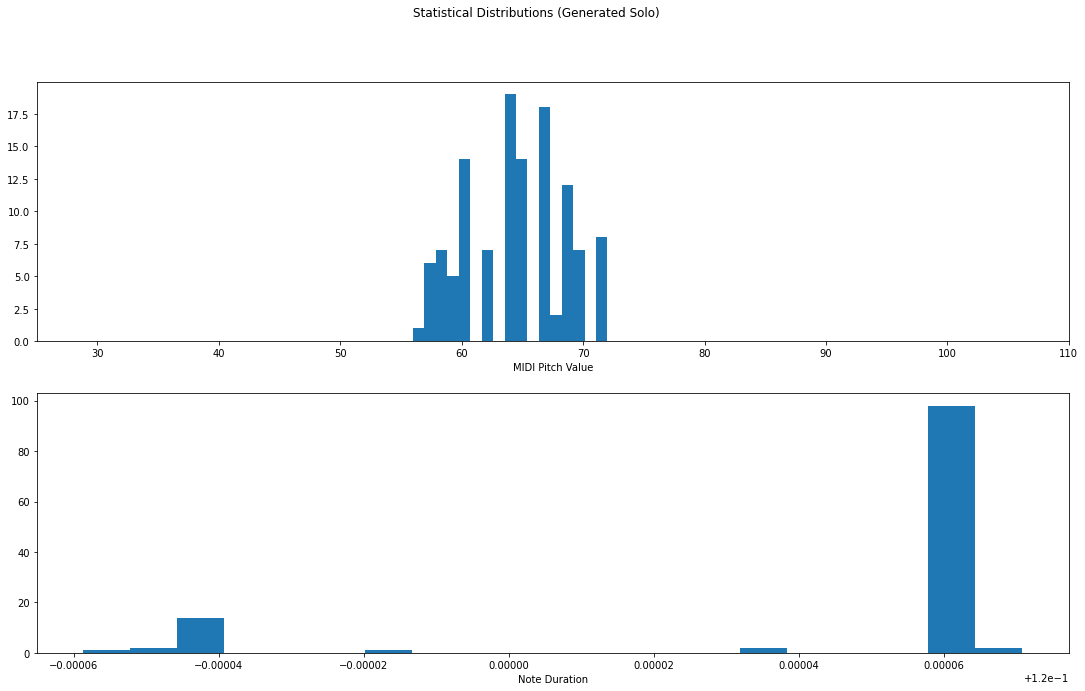

Generating 120 notes with temperature 3.000000...
Min pitch:  0
Max pitch:  127


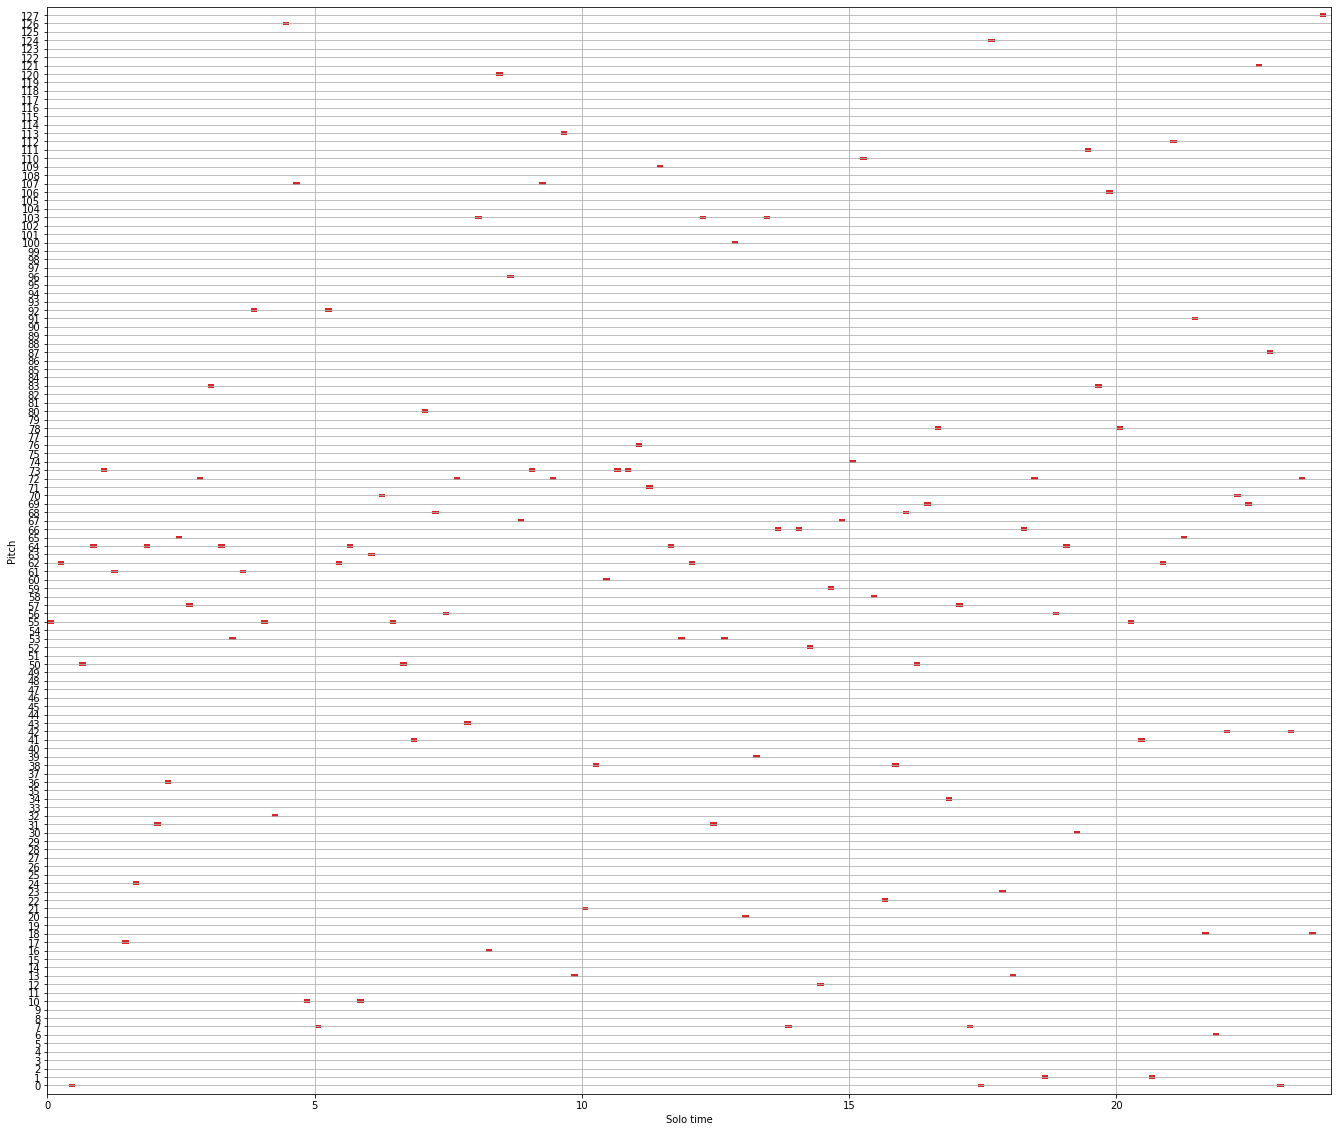

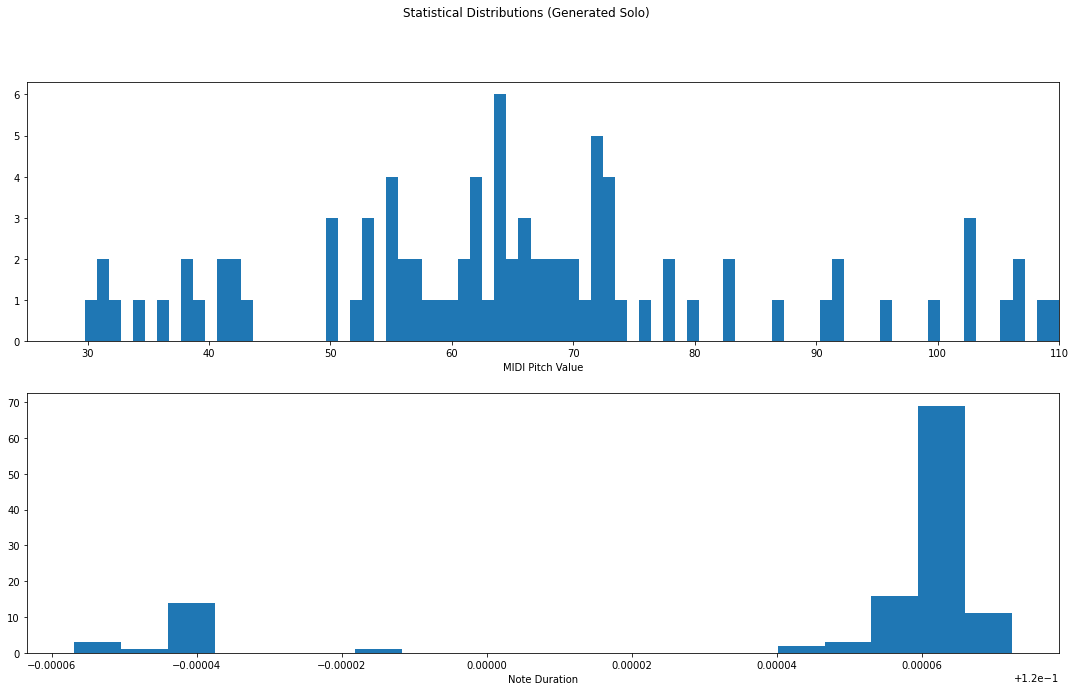

Generating 120 notes with temperature 10.000000...
Min pitch:  2
Max pitch:  127


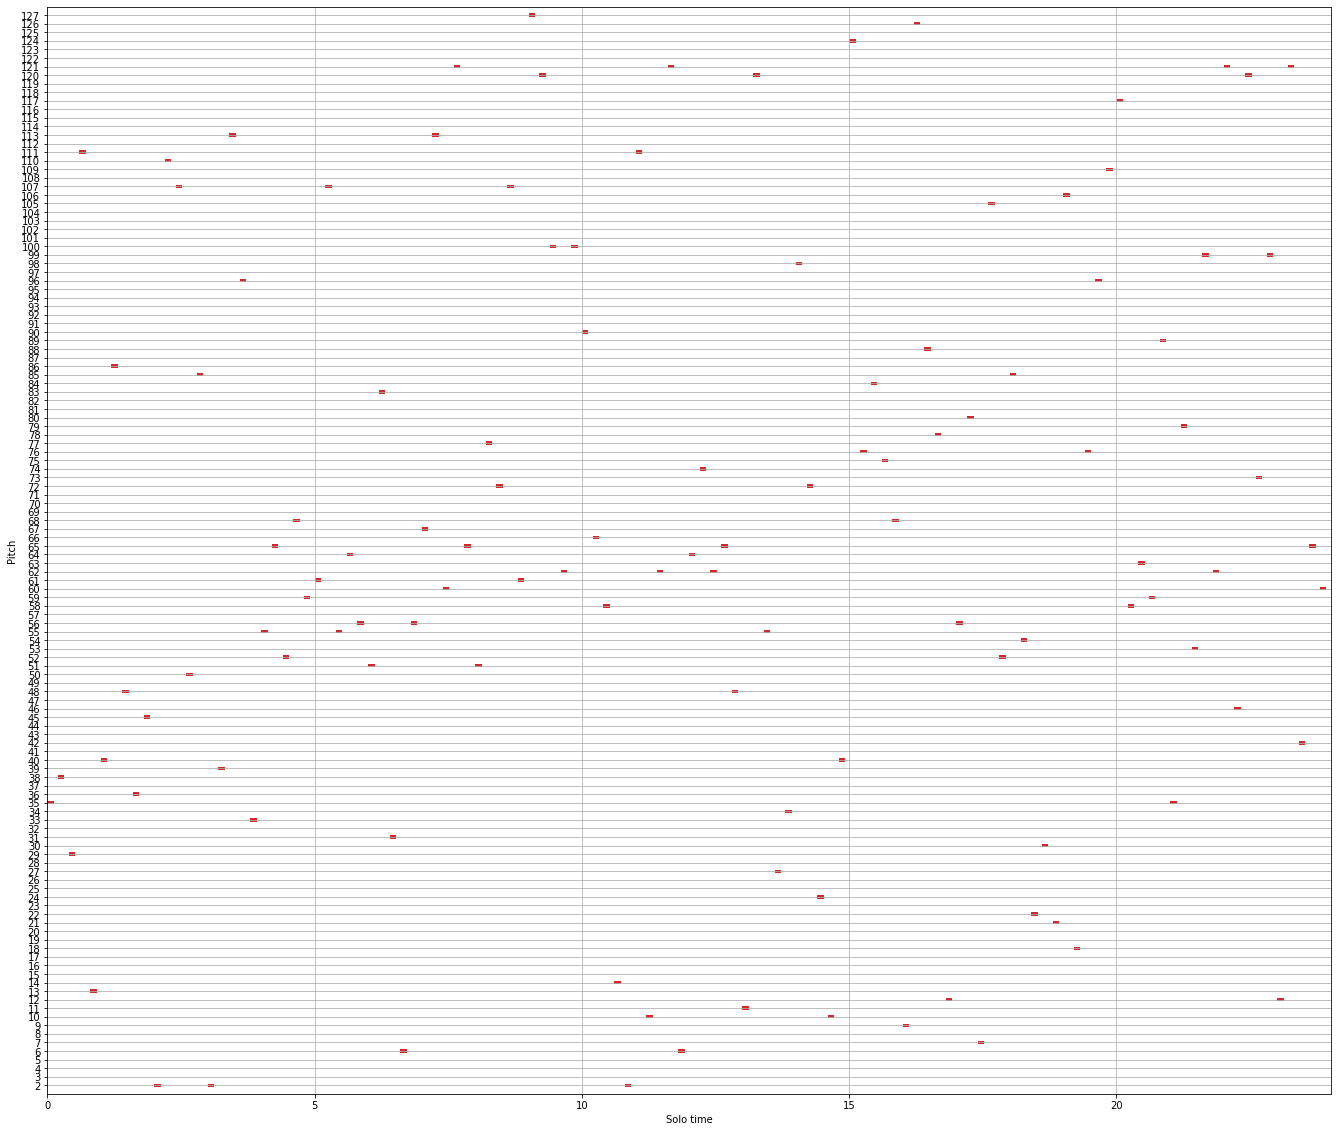

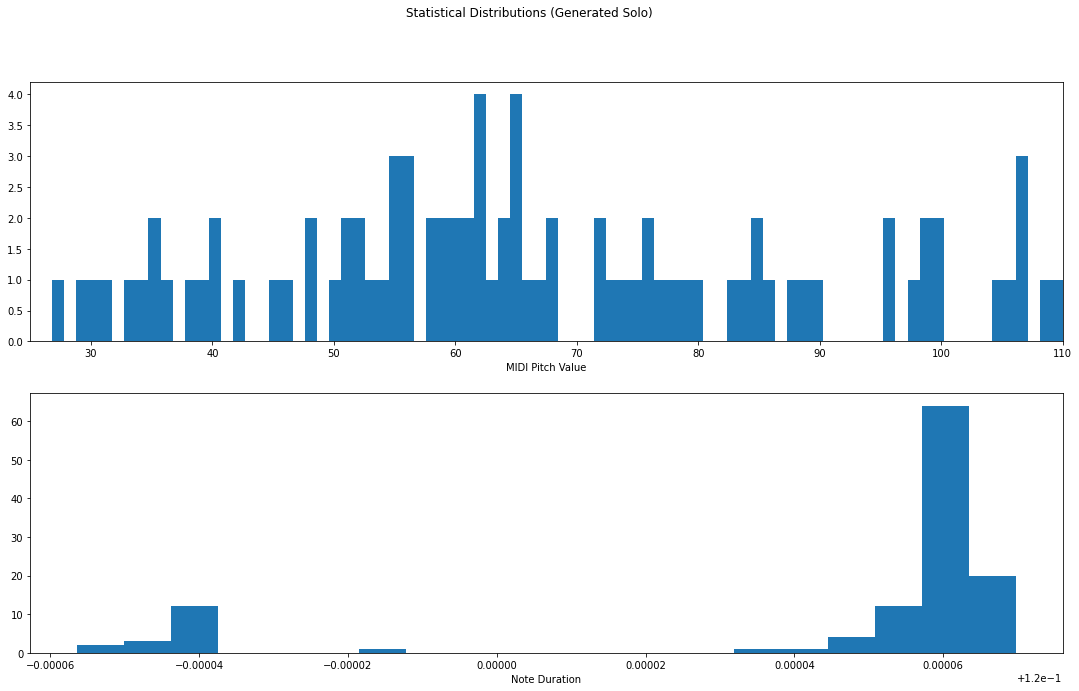

<class 'numpy.ndarray'>
4
0
1
2
3


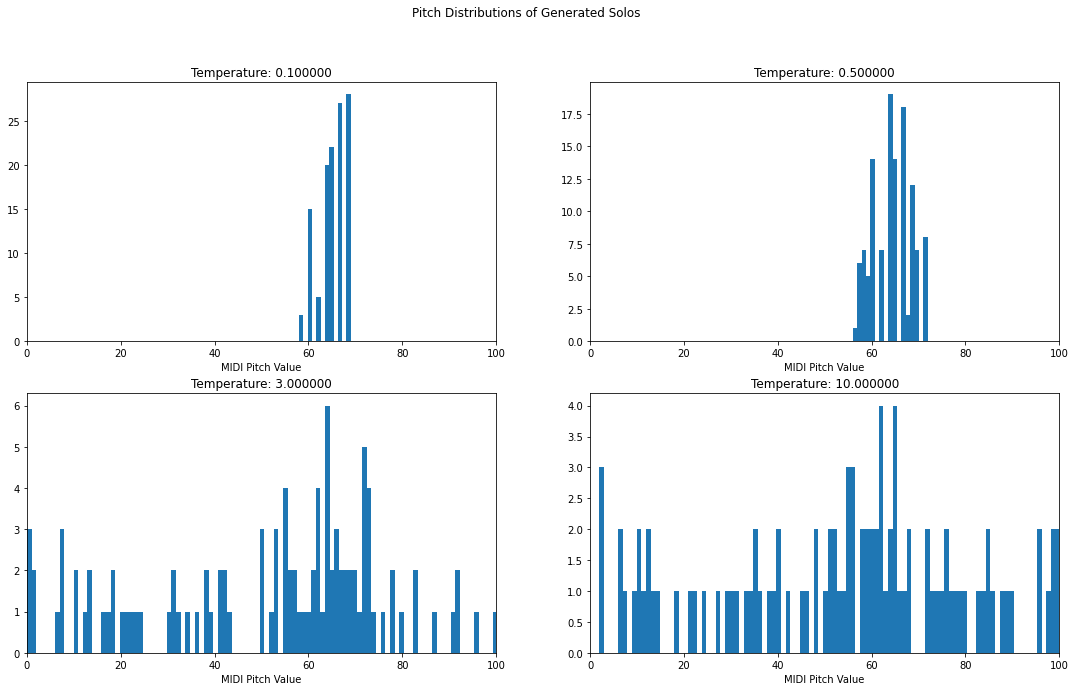

In [ ]:
# Visualizing how the temperature hyperparameter affects the pitch distribution

temps = [0.1, 0.5, 3.0, 10.0]
num_notes = 120

temp_results = []

for temp in temps:
  notes = generate_notes(num_notes, temp)
  temp_results.append(notes)
  visualize_notes(notes)

print_distributions(temp_results, temps)

In [ ]:
#We can also dump the reference solo for evaluation and comparison
out_file = '/content/OUTPUT_ORIG.mid'
instrument_name = 'trumpet'
out_pm = notes_to_midi(horiz, out_file = out_file, instrument_name = instrument_name)